2017 edition

# Building a music recommender system

As its name implies, a recommender system is a tool that helps predicting what a user may or may not like among a list of given items. In some sense, you can view this as an alternative to content search, as recommendation engines help users discover products or content that they may not come across otherwise. For example, Facebook suggests friends and pages to users. Youtube recommends videos which users may be interested in. Amazon suggests the products which users may need... Recommendation engines engage users to services, can be seen as a revenue optimization process, and in general help maintaining interest in a service.

In this notebook, we study how to build a simple recommender system: we focus on music recommendations, and we use a simple algorithm to predict which items users might like, that is called ALS, alternating least squares.

## Goals

In this lecture, we expect students to:

- Revisit (or learn) recommender algorithms

- Understand the idea of Matrix Factorization and the ALS algorithm (serial and parallel versions)

- Build a simple model for a real usecase: music recommender system

- Understand how to validate the results

## Steps

We assume students to work outside lab hours on the learning material. These are the steps by which we guide students, during labs, to build a good basis for the end-to-end development of a recommender system:

* Inspect the data using Spark SQL, and build some basic, but very valuable knowledge about the information we have at hand
* Formally define what is a sensible algorithm to achieve our goal: given the "history" of user taste for music, recommend new music to discover. Essentialy, we want to build a statistical model of user preferences such that we can use it to "predict" which additional music the user could like
* With our formal definition at hand, we will learn different ways to implement such an algorithm. Our goal here is to illustrate what are the difficulties to overcome when implementing a (parallel) algorithm
* Finally, we will focus on an existing implementation, available in the Apache Spark MLLib, which we will use out of the box to build a reliable statistical model

Now, you may think at this point we will be done!

Well, you'd better think twice: one important topic we will cover in all our Notebooks is **how to validate the results we obtain**, and **how to choose good parameters to train models** especially when using an "opaque" library for doing the job. As a consequence, we will focus on the statistical validation of our recommender system.

# 1. Data

Understanding data is one of the most important part when designing any machine learning algorithm. In this notebook, we will use a data set published by Audioscrobbler - a music recommendation system for last.fm. Audioscrobbler is also one of the first internet streaming radio sites, founded in 2002. It provided an open API for “scrobbling”, or recording listeners’ plays of artists’ songs. last.fm used this information to build a powerful music recommender engine.

## 1.1. Data schema

Unlike a rating dataset which contains information about users' preference for products (one star, 3 stars, and so on), the datasets from Audioscrobbler only has information about events: specifically, it keeps track of how many times a user played songs of a given artist and the names of artists. That means it carries less information than a rating: in the literature, this is called explicit vs. implicit ratings.

### Reading material

- [Implicit Feedback for Inferring User Preference: A Bibliography](http://people.csail.mit.edu/teevan/work/publications/papers/sigir-forum03.pdf)
- [Comparing explicit and implicit feedback techniques for web retrieval: TREC-10 interactive track report](http://trec.nist.gov/pubs/trec10/papers/glasgow.pdf)
- [Probabilistic Models for Data Combination in Recommender Systems](http://mlg.eng.cam.ac.uk/pub/pdf/WilGha08.pdf)

The data we use in this Notebook is available in 3 files (these files are stored in our HDFS layer, in the directory  ```/datasets/lastfm```):

- **`user_artist_data.txt`**: It contains about 140,000+ unique users, and 1.6 million unique artists. About 24.2 million users’ plays of artists’ are recorded, along with their count. It has 3 columns separated by spaces: 

| UserID | ArtistID | PlayCount |
|----|----|----|
| ...|...|...|


- **`artist_data.txt`** : It prodives the names of each artist by their IDs. It has 2 columns separated by tab characters (`\t`).

| ArtistID | Name |
|---|---|
|...|...|

- **`artist_alias.txt`**: Note that when plays are scrobbled, the client application submits the name of the artist being played. This name could be misspelled or nonstandard. For example, "The Smiths", "Smiths, The", and "the smiths" may appear as distinct artist IDs in the data set, even though they are plainly the same. `artist_alias.txt` maps artist IDs that are known misspellings or variants to the canonical ID of that artist. The data in this file has 2 columns separated by tab characters (`\t`).

| MisspelledArtistID | StandardArtistID |
|---|---|
|...|...|



In [1]:
import os
import sys
import re
import random
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql.types import *
from pyspark.sql import Row
from pyspark.sql.functions import *

%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from time import time

sqlContext = SQLContext(sc)
base = "/datasets/lastfm/"

## 1.2. Understanding data: simple descriptive statistic

In order to choose or design a suitable algorithm for achieving our goals, given the data we have, we should first understand data characteristics. To start, we import the necessary packages to work with regular expressions, Data Frames, and other nice features of our programming environment.

#### Take a look on raw dataset


In [2]:
user_artist_data = sc.textFile(base+"user_artist_data.txt")
user_artist_data.take(5)

['1000002 1 55',
 '1000002 1000006 33',
 '1000002 1000007 8',
 '1000002 1000009 144',
 '1000002 1000010 314']

### Question 1

#### Question 1.0 (Non-grading)

Using SPARK SQL, load data from `/datasets/lastfm/user_artist_data.txt` and show the first 20 entries (via function `show()`).

For this Notebook, from a programming point of view, we are given the schema for the data we use, which is as follows:

```
userID: long int
artistID: long int
playCount: int
```

Each line of the dataset contains the above three fields, separated by a "white space".

In [3]:
userArtistDataSchema = StructType([ \
    StructField("userID", LongType(), True), \
    StructField("artistID", LongType(), True), \
    StructField("playCount", IntegerType(), True)])

userArtistDF = sqlContext.read \
    .format('com.databricks.spark.csv') \
    .options(header='false', delimiter=' ') \
    .load(base + "user_artist_data.txt", schema = userArtistDataSchema) \
    .cache()

# we can cache an Dataframe to avoid computing it from the beginning everytime it is accessed.
userArtistDF.cache()

userArtistDF.show()

+-------+--------+---------+
| userID|artistID|playCount|
+-------+--------+---------+
|1000002|       1|       55|
|1000002| 1000006|       33|
|1000002| 1000007|        8|
|1000002| 1000009|      144|
|1000002| 1000010|      314|
|1000002| 1000013|        8|
|1000002| 1000014|       42|
|1000002| 1000017|       69|
|1000002| 1000024|      329|
|1000002| 1000025|        1|
|1000002| 1000028|       17|
|1000002| 1000031|       47|
|1000002| 1000033|       15|
|1000002| 1000042|        1|
|1000002| 1000045|        1|
|1000002| 1000054|        2|
|1000002| 1000055|       25|
|1000002| 1000056|        4|
|1000002| 1000059|        2|
|1000002| 1000062|       71|
+-------+--------+---------+
only showing top 20 rows



#### Question 1.1: 
How many distinct users do we have in our data? 

In [4]:
uniqueUsers = userArtistDF.select("userID").distinct().count()
print("Total n. of users: ", uniqueUsers)

Total n. of users:  148111


#### Question 1.2
How many distinct artists do we have in our data ?

In [4]:
uniqueArtists = userArtistDF.select("artistID").distinct().count()
print("Total n. of artists: ", uniqueArtists)

Total n. of artists:  1631028


#### Question 1.3

One limitation of Spark MLlib's ALS implementation - which we will use later - is that it requires IDs for users and items to be nonnegative 32-bit integers. This means that IDs larger than Integer.MAX_VALUE, or 2147483647, can't be used. So we need to check whether this data set conforms to the strict requirements of our library.

What are the maximum and minimum values of column `userID` ?

HINT: Refer to section 4.3 of Laboratory 2.

In [5]:
userArtistDF.agg(max('userID'),min('userID')).show()

+-----------+-----------+
|max(userID)|min(userID)|
+-----------+-----------+
|    2443548|         90|
+-----------+-----------+



<div style="background-color:rgba(249, 67, 6, 0.8); vertical-align: middle; padding:5px 0px 10px 10px;">
    <h3><font color='white'> ANSWER </font></h3>
</div>
The range of userID is [90,2443548]. It is wider than number of user (148,111 users). That means there are some userIDs which are not contained in this list. It can be users who never listen any artist in our system 

#### Question 1.4
What is the maximum and minimum values of column `artistID` ?

In [7]:
userArtistDF.agg(max('artistID'),min('artistID')).show()

+-------------+-------------+
|max(artistID)|min(artistID)|
+-------------+-------------+
|     10794401|            1|
+-------------+-------------+



<div style="background-color:rgba(249, 67, 6, 0.8); vertical-align: middle; padding:5px 0px 10px 10px;">
    <h3><font color='white'> ANSWER </font></h3>
</div>
The range of artistID have the same problem  as userID but numbers of artists who have not been listened are nearly 9 times more than numbers of artists in the list.

We discovered that there is a total of 148,111 users in our dataset and a total of 1,631,028 artists in our dataset. The maximum values of userID and artistID are still smaller than the biggest number of integer type. No additional transformation will be necessary to use these IDs.

One thing we can see here is that SPARK SQL provides very concise and powerful methods for data analytics (compared to using RDD and their low-level API). You can see more examples [here](https://databricks.com/blog/2015/06/02/statistical-and-mathematical-functions-with-dataframes-in-spark.html).

Next, we might want to understand better user activity and artist popularity.

Here is a list of simple descriptive queries that helps us reaching these purposes:

* How many **times each user** has **played a song**? This is a good indicator of who are the **most active users** of our service. Note that a very active user with many play counts does not necessarily mean that the user is also "curious"! Indeed, she could have played the same song several times.
* How many play **counts for each artist**? This is a good indicator of the **artist popularity**. Since we do not have time information associated to our data, we can only build a, e.g., top-10 ranking of the most popular artists in the dataset. Later in the notebook, we will learn that our dataset has a very "loose" definition about artists: very often artist IDs point to song titles as well. This means we have to be careful when establishing popular artists. Indeed, artists whose data is "well formed" will have the correct number of play counts associated to them. Instead, artists that appear mixed with song titles may see their play counts "diluted" across their songs.

### Question 2

#### Question 2.1
How many times each user has played a song? Show 5 samples of the result.

In [5]:
# Compute user activity
# We are interested in how many playcounts each user has scored.
userActivity = userArtistDF.groupBy('userID').sum('playCount').collect()
userActivity[0:5]

[Row(userID=1041783, sum(playCount)=8730),
 Row(userID=1042771, sum(playCount)=3),
 Row(userID=1043190, sum(playCount)=8),
 Row(userID=1043621, sum(playCount)=125),
 Row(userID=1043703, sum(playCount)=2609)]

#### Question 2.2
Plot CDF (or ECDF) of the number of play counts per User ID.

Explain and comment the figure you just created: 

* for example, look at important percentiles (25%, median, 75%, tails such as >90%) and cross check with what you have found above to figure out if the result is plausible.
* discuss about your users, with respect to the application domain we target in the notebook: you will notice that for some users, there is very little interaction with the system, which means that maybe reccommending something to them is going to be more difficult than for other users who interact more with the system.
* look at outliers and reason about their impact on your reccommender algorithm


[     0      1      2 ..., 148108 148109 148110]


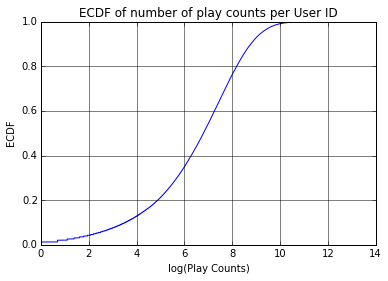

In [7]:
pdf = pd.DataFrame(data=userActivity)
Y=np.sort( pdf[1] )
yvals=np.arange(len(Y))/float(len(Y))

print(np.arange(len(Y)))

plt.plot( np.log(Y), yvals )
plt.xlabel('log(Play Counts)')
plt.ylabel('ECDF')
plt.grid(True,which="both",ls="-")
plt.title('ECDF of number of play counts per User ID')
plt.show()

Number of play count at a point [10%,25%,50%,75%,90%,99.9%] percentile:  [34, 204, 892, 2800, 6484, 10120, 50391]


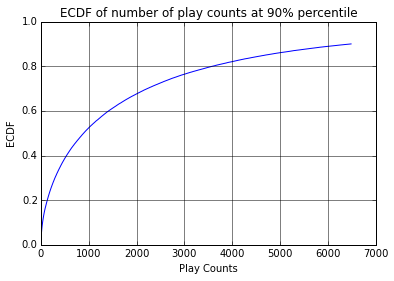

In [23]:
percentile = [0.1,0.25,0.5,0.75,0.9,0.95,0.999]
print("Number of play count at a point [10%,25%,50%,75%,90%,99.9%] percentile: ", \
      list(map(lambda x: Y[np.isclose(yvals,x)][0], percentile)))

ind = (Y<=6484)
plt.plot(Y[ind], yvals[ind] )
plt.xlabel('Play Counts')
plt.ylabel('ECDF')
plt.grid(True,which="both",ls="-")
plt.title('ECDF of number of play counts at 90% percentile')
plt.show()

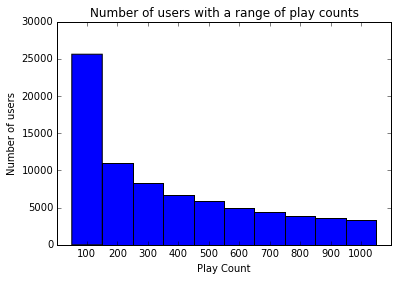

In [8]:
groupPCby10 = Y[(Y<=1000)]
label_groupPCby10 = [int(line/100)+1 for line in Y]
bins = np.arange(1,12)-0.5
plt.hist(label_groupPCby10,bins = bins)
plt.xticks(range(1,11),np.arange(1,11)*100)
plt.xlim([0, 11])
plt.xlabel('Play Count')
plt.ylabel('Number of users')
plt.title('Number of users with a range of play counts')

<div style="background-color:rgba(249, 67, 6, 0.8); vertical-align: middle; padding:5px 0px 10px 10px;">
    <h3><font color='white'> ANSWER </font></h3>
</div>

The distribution of data gives us an overview of data itself and leads us to some important conclusion about the data. In this case, distribution of play counts of users in our system is one of characteristic of users that we can use to group by. We can give assumptions like users can be active user, user that creates an account and never uses it again or user uses a bot to increase views for specific songs. While the average just gives us briefly about whole data set, it does not give any further information about these group of users. The percentiles are more meaningful than the average.

We calculate the play counts at different ratios of users. From the result shown above, we can see that 25% people listen to music less than 204 times, 50% people listen to music less than 892 times, 75% people listen to music less than 2800 times, 90% people listen to music less than 6484 times, and most of people(95%) listen to music less than 10120 times.

10120 is still much smaller than the maximam 674412(about 67 times of 10120). The distribution of the play counts which is larger than 6484 is sparse and the distribution is compact at the beginning. This indicates that a lot of people hardly interact with the system. Furthermore, you can see number of users that listens less than 100 times in our data is around 25.000, accounting for approxiamately 18% total user.


#### Question 2.3

How many play counts for each artist? Plot CDF or ECDF of the result.

Similarly to the previous question, you need to comment and interpret your result: what is the figure telling you?

In [12]:
artistPopularity = userArtistDF.groupBy('artistID').sum('playCount').collect()

print(artistPopularity[3])

pdf1 = pd.DataFrame(data=artistPopularity)

Row(artistID=1002519, sum(playCount)=405)


[      1       1       1 ..., 1930592 2259185 2502130]


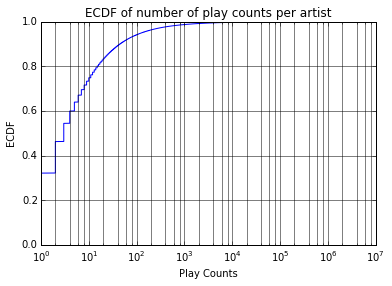

In [21]:
# Compute artist popularity
# We are interested in how many playcounts per artist
Z=np.sort(pdf1[1])
print(Z)
Zvals=np.arange(len(Z))/float(len(Z))

plt.semilogx(Z, Zvals)
plt.xlabel('Play Counts')
plt.ylabel('ECDF')
plt.grid(True,which="both",ls="-")
plt.title('ECDF of number of play counts per artist')
plt.show()

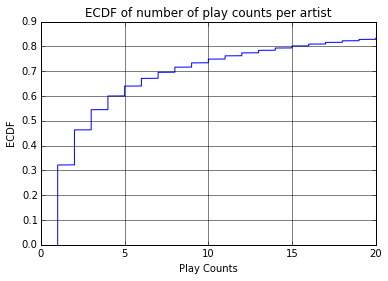

In [20]:
temp = Z<=20
plt.plot(Z[temp], Zvals[temp])
plt.xlabel('Play Counts')
plt.ylabel('ECDF')
plt.grid(True,which="both",ls="-")
plt.title('ECDF of number of play counts per artist')
plt.show()

<div style="background-color:rgba(249, 67, 6, 0.8); vertical-align: middle; padding:5px 0px 10px 10px;">
    <h3><font color='white'> ANSWER </font></h3>
</div>

Since the number of artists is too large and a lot of artists are only listerned for few times, we use the log of play counts to represent the ECDF to obtain better visualization.

Same as ECDF of number of play counts per user ID, most of the artists has play counts as 1. Only a small amount of artists are very popular.

The problem of this outliner is critical than one in userID, it means it is hard to recommend to user artists who are not too famous (less play counts) even those artists play same kind of music that user may like. Instead, users only receive recommendation of top artists, who dominates other artists by play counts. 

#### Question 2.4
Plot a bar chart to show top 5 artists In terms of absolute play counts.

Comment the figure you just obtained:

* are these reasonable results?
* is looking at top-5 artists enough to learn more about your data?
* do you see anything strange in the data?

[979, 1000113, 4267, 1000024, 4468] [2502130, 2259185, 1930592, 1542806, 1425942]


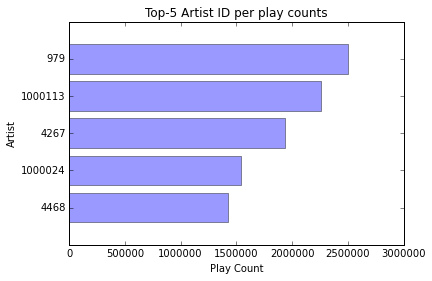

In [26]:
sortedArtist = sorted(artistPopularity, key = lambda x: -x[1])[:5]

artistID = [w[0] for w in sortedArtist]
y_pos = range(len(sortedArtist))
frequency = [w[1] for w in sortedArtist]
print(artistID,frequency)

plt.barh(y_pos, frequency[::-1], align='center', alpha=0.4)
plt.yticks(y_pos, artistID[::-1])
plt.xlabel('Play Count')
plt.ylabel('Artist')
plt.title('Top-5 Artist ID per play counts')
plt.show()

<div style="background-color:rgba(249, 67, 6, 0.8); vertical-align: middle; padding:5px 0px 10px 10px;">
    <h3><font color='white'> ANSWER </font></h3>
</div>

The most popular artist has around 2.5 milion play counts that means the average play count per user is about 17 times, which is reasonable number for playcounts.

It is not enough to learn about data, you can only know which artist is popular to overal user. There is nothing strange about the data.

All seem clear right now, but ... wait a second! What about the problems indicated above about artist "disambiguation"? Are these artist ID we are using referring to unique artists? How can we make sure that such "opaque" identifiers point to different bands? Let's try to use some additional dataset to answer this question:  `artist_data.txt` dataset. This time, the schema of the dataset consists in:

```
artist ID: long int
name: string
```

We will try to find whether a single artist has two different IDs.

### Question 3

#### Question 3.1
Load the data from `/datasets/lastfm/artist_data.txt` and use the SparkSQL API to show 5 samples.

HINT: If you encounter some error when parsing lines in data because of invalid entries, parameter `mode='DROPMALFORMED'` will help you to eliminate these entries. The suggested syntax is: `<df>.options(header='false', delimiter='\t', mode='DROPMALFORMED')`.

In [28]:
customSchemaArtist = StructType([ \
    StructField("artistID", LongType(), True), \
    StructField("name", StringType(), True)])

artistDF = sqlContext.read \
    .format('com.databricks.spark.csv') \
    .options(header='false', delimiter='\t', mode='DROPMALFORMED') \
    .load("/datasets/lastfm/artist_data.txt", schema = customSchemaArtist) \
    .cache()
    
artistDF.show(5)

+--------+--------------------+
|artistID|                name|
+--------+--------------------+
| 1134999|        06Crazy Life|
| 6821360|        Pang Nakarin|
|10113088|Terfel, Bartoli- ...|
|10151459| The Flaming Sidebur|
| 6826647|   Bodenstandig 3000|
+--------+--------------------+
only showing top 5 rows



#### Question 3.2
Find 20 artists whose name contains "Aerosmith". Take a look at artists that have ID equal to `1000010` and `2082323`. In your opinion, are they pointing to the same artist?

HINT: Function `locate(sub_string, string)` can be useful in this case.

In [29]:
# get artists whose name contains "Aerosmith"
artistDF[locate("Aerosmith", artistDF.name) > 0].show(20)
# show two examples
artistDF[artistDF.artistID==1000010].show()
artistDF[artistDF.artistID==2082323].show()

+--------+--------------------+
|artistID|                name|
+--------+--------------------+
|10586006|Dusty Springfield...|
| 6946007|    Aerosmith/RunDMC|
|10475683|Aerosmith: Just P...|
| 1083031|    Aerosmith/ G n R|
| 6872848|Britney, Nsync, N...|
|10586963|Green Day - Oasis...|
|10028830|The Aerosmith Ant...|
|10300357| Run-DMC + Aerosmith|
| 2027746|Aerosmith by Musi...|
| 1140418|[rap]Run DMC and ...|
|10237208| Aerosmith + Run DMC|
|10588537|Aerosmith, Kid Ro...|
| 9934757|Aerosmith - Big Ones|
|10437510|Green Day ft. Oas...|
| 6936680| RUN DNC & Aerosmith|
|10479781|      Aerosmith Hits|
|10114147|Charlies Angels -...|
| 1262439|Kid Rock, Run DMC...|
| 7032554|Aerosmith & Run-D...|
|10033592|          Aerosmith?|
+--------+--------------------+
only showing top 20 rows

+--------+---------+
|artistID|     name|
+--------+---------+
| 1000010|Aerosmith|
+--------+---------+

+--------+------------+
|artistID|        name|
+--------+------------+
| 2082323|01 Aerosmith|
+---

<div style="background-color:rgba(249, 67, 6, 0.8); vertical-align: middle; padding:5px 0px 10px 10px;">
    <h3><font color='white'> ANSWER </font></h3>
</div>
In our opinion, they are the same. The artist's name don't have official format (EX: Aerosmith/RunDMC,Aerosmith + Run DMC) and some of them also contain extra information.

To answer this question correctly, we need to use an additional dataset `artist_alias.txt` which contains the ids of mispelled artists and standard artists. The schema of the dataset consists in:

```
mispelledID ID: long int
standard ID: long int
```

#### Question 3.3
Using SparkSQL API, load the dataset from `/datasets/lastfm/artist_alias.txt` then show 5 samples.

In [30]:
customSchemaArtistAlias = StructType([ \
    StructField("MisspelledArtistID", LongType(), True ), \
    StructField("StandardArtistID", LongType(), True )])

artistAliasDF = sqlContext.read \
    .format('com.databricks.spark.csv') \
    .options(header='false', delimiter='\t', mode='DROPMALFORMED') \
    .load("/datasets/lastfm/artist_alias.txt", schema = customSchemaArtistAlias) \
    .cache()

artistAliasDF.show(5)


+------------------+----------------+
|MisspelledArtistID|StandardArtistID|
+------------------+----------------+
|           1092764|         1000311|
|           1095122|         1000557|
|           6708070|         1007267|
|          10088054|         1042317|
|           1195917|         1042317|
+------------------+----------------+
only showing top 5 rows



#### Question 3.4
Verify the answer of question 3.2 ("Are artists that have ID equal to `1000010` and `2082323` the same ?") by finding the standard ids corresponding to the mispelled ids `1000010` and `2082323` respectively.

In [41]:

artistAliasDF[artistAliasDF.MisspelledArtistID  == 1000010 ].show()
artistAliasDF[artistAliasDF.MisspelledArtistID  == 2082323 ].show()

# 1000010 is a standard id, so it haven't been considered as mispelled id in the dataset

+------------------+----------------+
|MisspelledArtistID|StandardArtistID|
+------------------+----------------+
+------------------+----------------+

+------------------+----------------+
|MisspelledArtistID|StandardArtistID|
+------------------+----------------+
|           2082323|         1000010|
+------------------+----------------+



<div style="background-color:rgba(249, 67, 6, 0.8); vertical-align: middle; padding:5px 0px 10px 10px;">
    <h3><font color='white'> ANSWER </font></h3>
</div>
As we can find the result, the answer for the previous one is **YES**

### Question 4

The mispelled or nonstandard information about artist make our results in the previous queries a bit "sloppy". To overcome this problem, we can replace all mispelled artist ids by the corresponding standard ids and re-compute the basic descriptive statistics on the "amended" data.
First, we construct a "dictionary" that maps non-standard ids to a standard ones. Then this "dictionary" will be used to replace the mispelled artists.

#### Question 4.1
From data in the dataframe loaded from `/datasets/lastfm/artist_alias.txt`, construct a dictionary that maps each non-standard id to its standard id.

HINT: Instead of using function `collect`, we can use `collectAsMap` to convert the collected data to a dictionary inline.

In [35]:
from time import time
t0 = time()
artistAlias = artistAliasDF.rdd.map(lambda row: ( row[0] , row[1])).collectAsMap()
t1 = time()
print('The script takes %f seconds' %(t1-t0))

The script takes 1.292234 seconds


In [32]:
from time import time
t0 = time()
artistAlias = artistAliasDF.rdd.map(lambda row: ( row[0] , row[1])).collect()
t1 = time()
print('The script takes %f seconds' %(t1-t0))

The script takes 1.098185 seconds


<div style="background-color:rgba(249, 67, 6, 0.8); vertical-align: middle; padding:5px 0px 10px 10px;">
    <h3><font color='white'> ANSWER </font></h3>
</div>
The performance of *collect()* and *collectAsMap()* are not different in this case.

#### Question 4.2
Using the constructed dictionary in question 4.1, replace the non-standard artist ids in the dataframe that was loaded from `/datasets/lastfm/user_artist_data.txt` by the corresponding standard ids then show 5 samples.

**NOTE 1**: If an id doesn't exist in the dictionary as a mispelled id, it is really a standard id.


Using funtion `map` on Spark Dataframe will give us an RDD. We can convert this RDD back to Dataframe by using `sqlContext.createDataFrame(rdd_name, sql_schema)`


**NOTE 2**: be careful! you need to be able to verify that you indeed solved the problem of having bad artist IDs. In principle, for the new data to be correct, we should to have duplicate pairs (user, artist), potentially with different play counts, right? In answering the question, please **show** that you indeed fixed the problem. 

In [36]:
from time import time
def replaceMispelledIDs(fields):
    finalID = artistAlias.get(fields[1], fields[1])
    return (fields[0], finalID, fields[2])

t0 = time()

newUserArtistDF = sqlContext.createDataFrame(
    userArtistDF.rdd.map(lambda row: replaceMispelledIDs(row)), 
    userArtistDataSchema
)
newUserArtistDF.show(5)

t1 = time()

print('The script takes %f seconds' %(t1-t0))

+-------+--------+---------+
| userID|artistID|playCount|
+-------+--------+---------+
|1000002|       1|       55|
|1000002| 1000006|       33|
|1000002| 1000007|        8|
|1000002| 1000009|      144|
|1000002| 1000010|      314|
+-------+--------+---------+
only showing top 5 rows

The script takes 1.276605 seconds


In [45]:
duplicate = userArtistDF.groupBy('userID', 'artistID').count().where('count > 1').count()
print("BEFORE: " + str(duplicate))
duplicate = newUserArtistDF.groupBy('userID', 'artistID').count().where('count > 1').count()
print("AFTER: " + str(duplicate))

#THIS SHOW THAT OUR METHOD RUN CORRECTLY, THERE IS DUPLICATION IN (USER,ARTIST) THAT MEANS USER LISTEN ON SAME ARTIST MANY TIME

BEFORE: 0
AFTER: 141922


<div style="background-color:rgba(249, 67, 6, 0.8); vertical-align: middle; padding:5px 0px 10px 10px;">
    <h3><font color='white'> ANSWER </font></h3>
</div>
*artistAlias.get(Para1,Para2)* if it cannot find *para1* in table it will get *para2* (in case starndard userID)

As you can see from the result, each pair (userID,artirstID) doesn't have duplication at the beginning, but there are 141922 duplications after we clean data. That means our method runs correctly.  

#### Question 4.3
Spark actions are executed through a set of stages, separated by distributed "shuffle" operations. Spark can be instructed to **automatically and efficiently** broadcast common data needed by tasks within **each stage**. The data broadcasted this way is cached in **serialized form** and deserialized before running each task. 

We can thus improve our answer to question 4.2: we can reduce the communication cost by shipping the "dictionary" in a more efficient way by using `broadcast variable`. Broadcast variables allow the programmer to keep a read-only variable cached on **each machine** rather than shipping a copy of it with tasks. They are cached in deserialized form. They can be used, for example, to give every node a copy of a large input dataset in an efficient manner. 

The broadcast of variable `v` can be created by `bV = sc.broadcast(v)`. Then value of this broadcast variable can be access via `bV.value`

To question is then: using a broadcast variable, modify the script in question 4.2 to get better performance in terms of running time.


In [35]:
bArtistAlias = []
newUserArtistDF = []
from time import time

def replaceMispelledIDs(fields):
    finalID = bArtistAlias.value.get( fields[1], fields[1])
    return (fields[0], finalID, fields[2])

t0 = time()
bArtistAlias = sc.broadcast(artistAlias)
newUserArtistDF = sqlContext.createDataFrame(
    userArtistDF.rdd.map(replaceMispelledIDs), 
    userArtistDataSchema
)
newUserArtistDF.show(5)
t1 = time()

print('The script takes %f seconds' %(t1-t0))
newUserArtistDF = newUserArtistDF.cache()

+-------+--------+---------+
| userID|artistID|playCount|
+-------+--------+---------+
|1000002|       1|       55|
|1000002| 1000006|       33|
|1000002| 1000007|        8|
|1000002| 1000009|      144|
|1000002| 1000010|      314|
+-------+--------+---------+
only showing top 5 rows

The script takes 0.327428 seconds


<div style="background-color:rgba(249, 67, 6, 0.8); vertical-align: middle; padding:5px 0px 10px 10px;">
    <h3><font color='white'> ANSWER </font></h3>
</div>

We noticed that you don't include broadcast pharse into cleaning data task. When we tried it, the process time increase a little bit but it is still much smaller than those we don't use broadcast. Why is it efficient when we have only 1 stage?

The data is divided into many partitions and each group have only 2 executor to run the task. Without broadcast, we have to attached ArtistAlias to each partitions (ex: if we have 10 partitions, we have to send ArtistAlias 10 times). If we use broadcast, we only need to send ArtistAlias to 2 executors, that is why we achieved shorter process time in this case 

Although having some advantages, explicitly creating broadcast variables is only useful when tasks across multiple stages need the same data or when caching the data in deserialized form is important.

### Question 5

Well, our data frame contains clean and "standard" data. We can use it to redo previous statistic queries.

#### Question 5.1

How many unique artists? Compare with the result when using old data.

In [54]:
uniqueArtists = newUserArtistDF.select("ArtistID").distinct().count()

print("Total n. of artists: ", uniqueArtists)


Total n. of artists:  1568126


<div style="background-color:rgba(249, 67, 6, 0.8); vertical-align: middle; padding:5px 0px 10px 10px;">
    <h3><font color='white'> ANSWER </font></h3>
</div>

Total n. of artists reduce from 1631028 in old data to 1568126 in cleaned data because it removes some mispelled name in artist.

#### Question 5.2

Who are the top-10 artistis?
  * In terms of absolute play counts
  * In terms of "audience size", that is, how many users listened to one of their track at least once
  
Plot the results, and explain the figures you obtain.

### In terms of absolute play counts

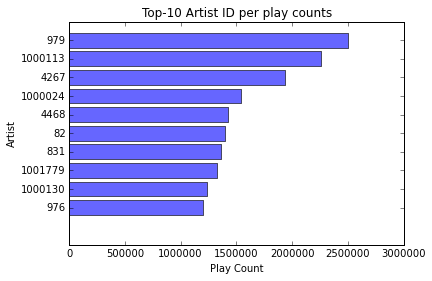

In [36]:
# calculate top-10 artists in term of play counts
top10ArtistsPC = newUserArtistDF.groupBy('artistID').sum('playCount').orderBy('sum(playCount)', ascending=0).take(10)

y_pos = range(len(top10ArtistsPC))
pdf = pd.DataFrame(data=top10ArtistsPC)

plt.barh(y_pos, pdf[1][::-1], align='center', alpha=0.6)
plt.yticks(y_pos[::-1], pdf[0])
plt.xlabel('Play Count')
plt.ylabel('Artist')
plt.title('Top-10 Artist ID per play counts')
plt.show()

### In terms of "audience size", that is, how many users listened to one of their track at least once

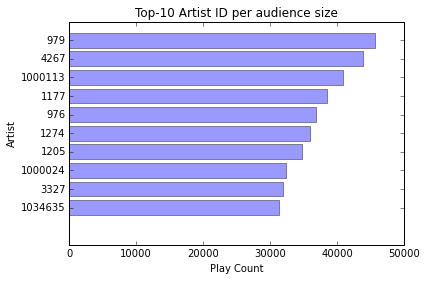

In [37]:
# calculate top-10 artists in term of play counts
top10ArtistsIDbyPC = [row[0] for row in top10ArtistsPC]
top10ArtistsAS = newUserArtistDF.dropDuplicates(['userID','artistID']) \
                .groupBy('artistID').count().orderBy('count', ascending=0).take(10)
#[newUserArtistDF['artistID'].isin(top10ArtistsIDbyPC)]
pdf = pd.DataFrame(data=top10ArtistsAS)

plt.barh(y_pos, pdf[1][::-1], align='center', alpha=0.4)
plt.yticks(y_pos[::-1], pdf[0])
plt.xlabel('Play Count')
plt.ylabel('Artist')
plt.title('Top-10 Artist ID per audience size')
plt.show()

<div style="background-color:rgba(249, 67, 6, 0.8); vertical-align: middle; padding:5px 0px 10px 10px;">
    <h3><font color='white'> ANSWER </font></h3>
</div>

In both graphs, 5 most common artist IDs by play count and by fan (distinct user listen their music) is different, which means some artirsts have higher average play count per user than others. 

However, those artists are also on the top of the list that means the popularity of artist over users and the number of playcount have some corelations.

In [144]:
#artistDF.filter(lambda line: line.artistID in top10ArtistsIDbyPC)
artistDF[artistDF["artistID"].isin(top10ArtistsIDbyPC)].show()
top10ArtistsIDbyAS =  [row[0] for row in top10ArtistsAS ]
artistDF[artistDF["artistID"].isin(top10ArtistsIDbyAS)].show()

+--------+----------------+
|artistID|            name|
+--------+----------------+
|    4468|System of a Down|
| 1000024|       Metallica|
| 1000130|     Bright Eyes|
| 1000113|     The Beatles|
| 1001779|    Modest Mouse|
|     979|       Radiohead|
|     976|         Nirvana|
|      82|      Pink Floyd|
|     831| Nine Inch Nails|
|    4267|       Green Day|
+--------+----------------+

+--------+--------------------+
|artistID|                name|
+--------+--------------------+
| 1034635|           [unknown]|
| 1000024|           Metallica|
| 1000113|         The Beatles|
|     979|           Radiohead|
|    1274|Red Hot Chili Pep...|
|    1177|            Coldplay|
|    1205|                  U2|
|     976|             Nirvana|
|    3327|              Weezer|
|    4267|           Green Day|
+--------+--------------------+



In [148]:
userArtistDF[userArtistDF.artistID == "1034635"].groupby("artistID").sum("playCount").show()

+--------+--------------+
|artistID|sum(playCount)|
+--------+--------------+
| 1034635|        348383|
+--------+--------------+



<div style="background-color:rgba(249, 67, 6, 0.8); vertical-align: middle; padding:5px 0px 10px 10px;">
    <h3><font color='white'> ANSWER </font></h3>
</div>

Because we see in the result of recommendation, the system recommends "unknown" artist for some users, I want to check whether 'unknown' is in the most popular artist by popularity or by playcount. We saw that "unknown"'s song is listened by over 30.000 users. "unknown" is invalid value for subtitution in case missing data so the first idea that problem in recommendation occur is "unknown" artists is listened by over users that are different "taste of music". When we try to recommend for new user who have specific "taste of music", "unknown" have high priority for system to recommend. We will try more test later to give better conclusion

#### Question 5.3

Who are the top-10 users?
  * In terms of absolute play counts
  * In terms of "curiosity", that is, how many different artists they listened to

Plot the results

[Row(userID=1059637, sum(playCount)=674412), Row(userID=2064012, sum(playCount)=548427), Row(userID=2069337, sum(playCount)=393515), Row(userID=2023977, sum(playCount)=285978), Row(userID=1046559, sum(playCount)=183972), Row(userID=1052461, sum(playCount)=175822), Row(userID=1070932, sum(playCount)=168977), Row(userID=1031009, sum(playCount)=167273), Row(userID=2020513, sum(playCount)=165642), Row(userID=2062243, sum(playCount)=151504)]


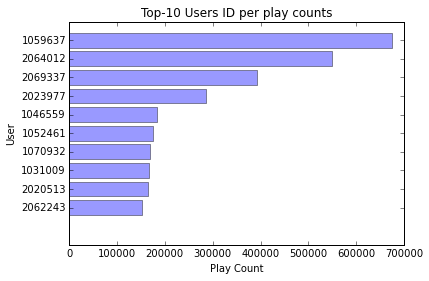

In [38]:
# calculate top 10 users interm of play counts
top10UsersByPlayCount=newUserArtistDF.groupBy('userID').sum('playCount').orderBy('sum(playCount)',ascending=0).take(10)

print(top10UsersByPlayCount)

y_pos = range(len(top10UsersByPlayCount))
pdf = pd.DataFrame(data=top10UsersByPlayCount)

plt.barh(y_pos, pdf[1][::-1], align='center', alpha=0.4)
plt.yticks(y_pos[::-1], pdf[0])
plt.xlabel('Play Count')
plt.ylabel('User')
plt.title('Top-10 Users ID per play counts')
plt.show()

[Row(userID=2030067, count=6735), Row(userID=1024631, count=6125), Row(userID=1059334, count=5839), Row(userID=2016026, count=5773), Row(userID=2023686, count=4822), Row(userID=1045464, count=4734), Row(userID=1004584, count=4690), Row(userID=2010008, count=4411), Row(userID=2232770, count=4090), Row(userID=1006093, count=4005)]


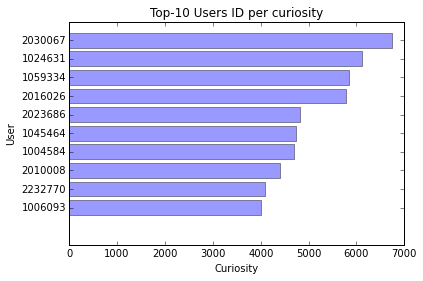

In [39]:
top10UsersByCuriosity = newUserArtistDF.dropDuplicates(['UserID','ArtistID']).groupBy('userID').count().orderBy('count',ascending=0).take(10)
print(top10UsersByCuriosity)

y_pos = range(len(top10UsersByCuriosity))
pdf = pd.DataFrame(data=top10UsersByCuriosity)

plt.barh(y_pos, pdf[1][::-1], align='center', alpha=0.4)
plt.yticks(y_pos[::-1], pdf[0])
plt.xlabel('Curiosity')
plt.ylabel('User')
plt.title('Top-10 Users ID per curiosity')
plt.show()

In [27]:
userArtistDF[userArtistDF.userID == "1059637"].orderBy('playCount',ascending=0).show(5)

+-------+--------+---------+
| userID|artistID|playCount|
+-------+--------+---------+
|1059637| 1002095|   433060|
|1059637| 1026440|   155895|
|1059637| 1000130|    19129|
|1059637| 1238230|     9294|
|1059637|    1193|     7665|
+-------+--------+---------+
only showing top 5 rows



<div style="background-color:rgba(249, 67, 6, 0.8); vertical-align: middle; padding:5px 0px 10px 10px;">
    <h3><font color='white'> ANSWER </font></h3>
</div>


In this case, we can see that top 10 users by playcount and by curiousity are different. We can conclude that there is low corelation between playcount and curiosity of a same user.

In addition, the top and second user by play count are dramatically different to others. Another evidence is number of playcount of a pair (userID,artistID). For example user 1059637 listens artist "1002095" for 433060 times and artist "1026440" for 155895 times, accounting for 85% of total play count of that user. Finally, we raise assume that user is not a human, it is possible someone use that to increase the view. 

<div style="background-color:#0080ff; vertical-align: middle; padding:5px 0px 10px 10px;">
    <h1><font color='white'> FINDING BETTER WAY TO REPRESENT "RATING" FEATURE </font></h1>
</div>


In [40]:
userByArtist = newUserArtistDF.dropDuplicates(['UserID','ArtistID']).groupBy('userID').count().orderBy('UserID')
userByPlayCount = newUserArtistDF.groupBy('userID').sum('playCount').orderBy('UserID')

X = userByPlayCount.select("sum(playCount)").collect()
Y = userByArtist.select("count").collect()
X = [x[0] for x in X]
Y = [y[0] for y in Y]

/opt/conda/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


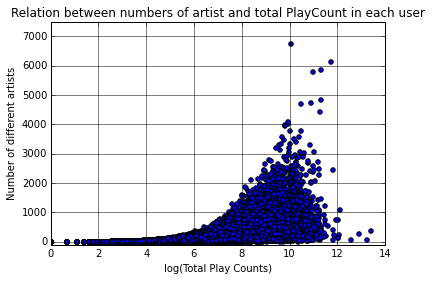

In [66]:
plt.scatter( np.log(X),Y)
plt.xlabel('log(Total Play Counts)')
plt.ylabel('Number of different artists')
plt.grid(True,which="both",ls="-")
plt.title('Relation between numbers of artist and total PlayCount in each user')
plt.ylim(-100, 7500)
plt.xlim(0,14)
plt.show()

/opt/conda/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


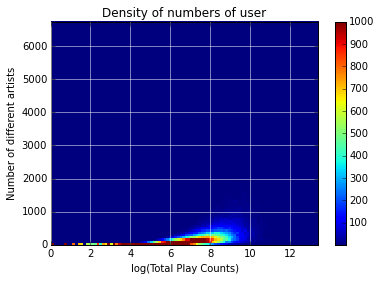

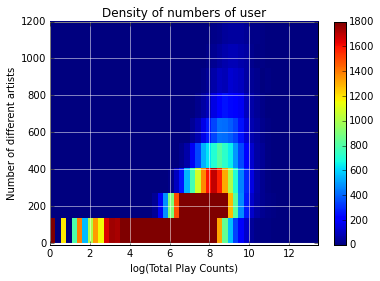

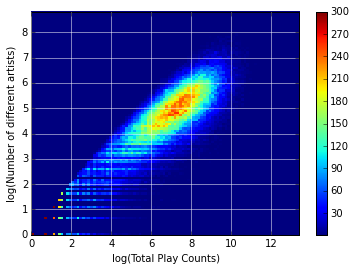

In [138]:
from scipy.stats import gaussian_kde
x = np.array(np.log(X))
y = np.array(Y)

plt.hist2d(x, y, (100, 100), cmap=plt.cm.jet,vmin=1, vmax=1000)
plt.colorbar()
plt.xlabel('log(Total Play Counts)')
plt.ylabel('Number of different artists')
plt.grid(True,which="both",ls="-",c="w")
plt.title('Density of numbers of user')
plt.show()

plt.hist2d(x, y, (50, 50), cmap=plt.cm.jet,vmin=1, vmax=1800)
plt.colorbar()
plt.xlabel('log(Total Play Counts)')
plt.ylabel('Number of different artists')
plt.ylim(-10,1200)
plt.grid(True,which="both",ls="-",c="w")
plt.title('Density of numbers of user')
plt.show()

plt.hist2d(x, np.log(y), (100, 100), cmap=plt.cm.jet,vmin=1, vmax=300)
plt.colorbar()
plt.xlabel('log(Total Play Counts)')
plt.ylabel('log(Number of different artists)')
plt.grid(True,which="both",ls="-",c="w")
plt.show()



<div style="background-color:rgba(249, 67, 6, 0.8); vertical-align: middle; padding:5px 0px 10px 10px;">
    <h3><font color='white'> IDEA </font></h3>
</div>

Users who listen only one time in the system are not useful to training the model. It can be the user who accidentally listen a song after they register. 

Users who listen many kinds of music (lots of artists in this case) are also not useful because they can be similar with lots of user. If we recommend songs from user listening many kinds of music to user listening only 1 or 2 kinds of music, it won't be good. 

So we need a weight that is proportional to total play counts and inversely proportional to numbers of different artists for each user. But the range of total playcount and number of different artists are [1-700.000] and [1-7000] correspondingly. It is quite broad even we try with ratio between them. In the last figure,we show you density of numbers of user by 2 dimensions we mentions above. We want to consider users that in the cloud whose range is from 150~300. We propose new rating = PlayCount * log(Total play count of that user)/(2*log(Number of different artists of that user))

In [58]:
userAggPlayCount = newUserArtistDF.groupBy('userID').sum('playCount')
userAggPC5 = userAggPlayCount[userAggPlayCount["sum(playCount)"]<6].collect()
listUserAggPC5 = [x[0] for x in userAggPC5]
print("NUMBER OF USER LISTEN LESS THAN 6 Times: ", len(listUserAggPC5))

NUMBER OF USER LISTEN LESS THAN 6 Times:  5230


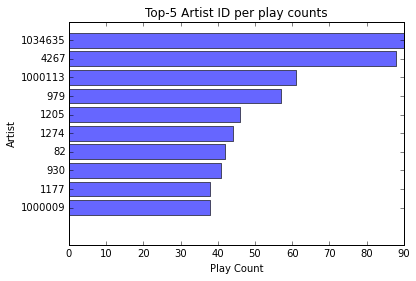

In [57]:
userPC5 = newUserArtistDF[newUserArtistDF["userID"].isin(listUserAggPC5)]
top10ArtistsPC5 = userPC5.groupBy('artistID').sum('playCount').orderBy('sum(playCount)', ascending=0).take(10)

y_pos = range(len(top10ArtistsPC5))
pdf = pd.DataFrame(data=top10ArtistsPC5)

plt.barh(y_pos, pdf[1][::-1], align='center', alpha=0.6)
plt.yticks(y_pos[::-1], pdf[0])
plt.xlabel('Play Count')
plt.ylabel('Artist')
plt.title('Top-5 Artist ID per play counts')
plt.show()

<div style="background-color:rgba(249, 67, 6, 0.8); vertical-align: middle; padding:5px 0px 10px 10px;">
    <h3><font color='white'> USER LISTENS LESS THAN 5 TIMES IN THE SYSTEM </font></h3>
</div>
As we mentioned above, The user listens less than 5 time is 5230 and the number of playcount of the most popular artist in this population is 90. So we show that population of new user randomly listen artists. 

In addition, if you compare it with top-10 artist by playcount, we don't see any relations. That is an evidence to strengthen our conclusion above.

In [59]:
top10UsersByPlayCount

[Row(userID=1059637, sum(playCount)=674412),
 Row(userID=2064012, sum(playCount)=548427),
 Row(userID=2069337, sum(playCount)=393515),
 Row(userID=2023977, sum(playCount)=285978),
 Row(userID=1046559, sum(playCount)=183972),
 Row(userID=1052461, sum(playCount)=175822),
 Row(userID=1070932, sum(playCount)=168977),
 Row(userID=1031009, sum(playCount)=167273),
 Row(userID=2020513, sum(playCount)=165642),
 Row(userID=2062243, sum(playCount)=151504)]

In [108]:
def ratioTopArtist(userID):
    userPCS = newUserArtistDF[newUserArtistDF["userID"]==userID]
    totalPCS = userPCS.agg(sum("playCount")).collect()[0][0]
    top10ArtistsUser = userPCS.groupBy('artistID').agg((sum('playCount')/totalPCS).alias('ratio')) \
                        .orderBy('ratio', ascending=0).take(10)
    return pd.DataFrame(top10ArtistsUser)

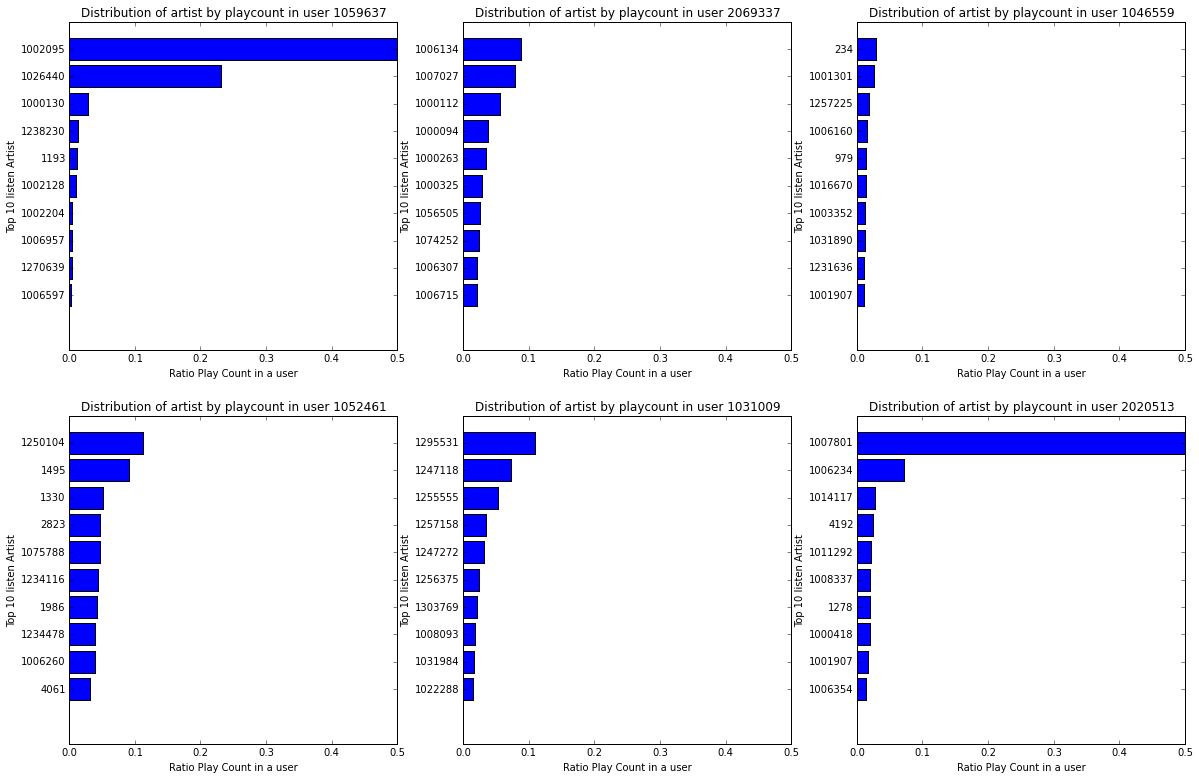

In [155]:
plt.figure(1,figsize=(20,20))
plt.subplot(3,3,1)
pdf = ratioTopArtist(1059637)
y_pos = range(len(pdf[1]))
plt.barh(y_pos,pdf[1][::-1],align="center")
plt.yticks(y_pos[::-1], pdf[0])
plt.xlabel('Ratio Play Count in a user')
plt.xlim(0,0.5)
plt.ylabel('Top 10 listen Artist')
plt.title('Distribution of artist by playcount in user 1059637')

plt.subplot(3,3,2)
pdf = ratioTopArtist(2069337)
y_pos = range(len(pdf[1]))
plt.barh(y_pos,pdf[1][::-1],align="center")
plt.yticks(y_pos[::-1], pdf[0])
plt.xlim(0,0.5)
plt.xlabel('Ratio Play Count in a user')
plt.ylabel('Top 10 listen Artist')
plt.title('Distribution of artist by playcount in user 2069337')

plt.subplot(3,3,3)
pdf = ratioTopArtist(1046559)
y_pos = range(len(pdf[1]))
plt.barh(y_pos,pdf[1][::-1],align="center")
plt.yticks(y_pos[::-1], pdf[0])
plt.xlabel('Ratio Play Count in a user')
plt.xlim(0,0.5)
plt.ylabel('Top 10 listen Artist')
plt.title('Distribution of artist by playcount in user 1046559')

plt.subplot(3,3,4)
pdf = ratioTopArtist(1052461)
y_pos = range(len(pdf[1]))
plt.barh(y_pos,pdf[1][::-1],align="center")
plt.xlim(0,0.5)
plt.yticks(y_pos[::-1], pdf[0])
plt.xlabel('Ratio Play Count in a user')
plt.ylabel('Top 10 listen Artist')
plt.title('Distribution of artist by playcount in user 1052461')

plt.subplot(3,3,5)
pdf = ratioTopArtist(1031009)
y_pos = range(len(pdf[1]))
plt.barh(y_pos,pdf[1][::-1],align="center")
plt.yticks(y_pos[::-1], pdf[0])
plt.xlabel('Ratio Play Count in a user')
plt.ylabel('Top 10 listen Artist')
plt.xlim(0,0.5)
plt.title('Distribution of artist by playcount in user 1031009')

plt.subplot(3,3,6)
pdf = ratioTopArtist(2020513)
y_pos = range(len(pdf[1]))
plt.barh(y_pos,pdf[1][::-1],align="center")
plt.yticks(y_pos[::-1], pdf[0])
plt.xlim(0,0.5)
plt.xlabel('Ratio Play Count in a user')
plt.ylabel('Top 10 listen Artist')
plt.title('Distribution of artist by playcount in user 2020513')


<div style="background-color:rgba(249, 67, 6, 0.8); vertical-align: middle; padding:5px 0px 10px 10px;">
    <h3><font color='white'> USER LISTENS ONLY SOME ARTIST OR KIND OF MUSIC</font></h3>
</div>
As we want to check our second hypothesis, The user listens only some kinds of music. You can see some users only listen some artist and some listen many artist. However, we need a data to check whether those artists are relative or not.


Now we have some valuable information about the data. It's the time to study how to build a statistical models.

# 2. Build a statistical models to make recommendations

## 2.1 Introduction to recommender systems

In a recommendation-system application there are two classes of entities, which we shall refer to as `users` and `items`. Users have preferences for certain items, and these preferences must be inferred from the data. The data itself is represented as a `preference matrix` $A$, giving for each user-item pair, a value that represents what is known about the degree of preference of that user for that item. The table below is an example for a `preference matrix` of 5 users and `k` items. The `preference matrix` is also known as `utility matrix`.

| | IT1 | IT2 | IT3 | ... | ITk |
|---|---|---|---|---|---|
| U1 | 1 |  | 5 | ... | 3 |
| U2 |  | 2 |  | ... | 2 |
| U3 | 5 |  | 3 | ... |  |
| U4 | 3 | 3 |  | ... | 4 |
| U5 |  | 1 |  | ... | ... |

The value of row i, column j expresses how much does user `i` like item `j`. The values are often the rating scores of users for items. An unknown value implies that we have no explicit information about the user's preference for the item. The goal of a recommendation system is to predict "the blanks" in the `preference matrix`. For example, assume that the rating score is from 1 (dislike) to 5 (love), would user `U5` like `IT3` ? We have two approaches:

* Designing our recommendation system to take into account properties of items such as brand, category, price... or even the similarity of their names. We can denote the **similarity of items `IT2` and `IT3`**, and then conclude that because user `U5` did not like `IT2`, they were unlikely to enjoy SW2 either.

* We might observe that **the people who rated both `IT2` and `IT3` tended to give them similar ratings**. Thus, we could conclude that user `U5` would also give `IT3` a low rating, similar to `U5`'s rating of `IT2`

It is not necessary to predict every blank entry in a `utility matrix`. Rather, it is only necessary to discover some entries in each row that are likely to be high. In most applications, the recommendation system does not oﬀer users a ranking of all items, but rather suggests a few that the user should value highly. It may not even be necessary to ﬁnd all items with the highest expected ratings, but only to ﬁnd a large subset of those with the highest ratings.


## 2.2 Families of recommender systems

In general, recommender systems can be categorized into two groups:

* **Content-Based** systems **focus on properties of items**. Similarity of items is determined by measuring the similarity in their properties.

* **Collaborative-Filtering** systems focus on the **relationship between users and items**. Similarity of items is determined by the similarity of the ratings of those items by the users who have rated both items.

In the usecase of this notebook, artists take the role of `items`, and `users` keep the same role as `users`.
Since we have no information about `artists`, except their names, we cannot build a `content-based` recommender system.

Therefore, in the rest of this notebook, we only focus on `Collaborative-Filtering` algorithms.

## 2.3 Collaborative-Filtering 
In this section, we study a member of a broad class of algorithms called `latent-factor` models. They try to explain observed interactions between large numbers of users and products through a relatively small number of unobserved, underlying reasons. It is analogous to explaining why millions of people buy a particular few of thousands of possible albums by describing users and albums in *terms of tastes* for perhaps tens of genres, tastes which are **not directly observable or given** as data. 

First, we formulate the learning problem as a matrix completion problem. Then, we will use a type of `matrix factorization` model to "fill in" the blanks.  We are given implicit ratings that users have given certain items (that is, the number of times they played a particular artist) and our goal is to predict their ratings for the rest of the items. Formally, if there are $n$ users and $m$ items, we are given an $n \times m$ matrix $R$ in which the generic entry $(u, i)$ represents the rating for item $i$ by user $u$. **Matrix $R$ has many missing entries indicating unobserved ratings, and our task is to estimate these unobserved ratings**.

A popular approach to the matrix completion problem is **matrix factorization**, where we want to "summarize" users and items with their **latent factors**.

# 3. Usecase : Music recommender system

In this usecase, we use the data of users and artists in the previous sections to build a statistical model to recommend artists for users.
 
## 3.1 Requirements
According to the properties of data, we need to choose a recommender algorithm that is suitable for this implicit feedback data. It means that the algorithm should learn without access to user or artist attributes such as age, genre,.... Therefore, an algorithm of type `collaborative filtering` is the best choice.

Second, in the data, there are some users that have listened to only 1 artist. We need an algorithm that might provide decent recommendations to even these users. After all, at some point, every user starts out with just one play at some point! 

Third, we need an algorithm that scales, both in its ability to build large models, and to create recommendations quickly. So, an algorithm which can run on a distributed system (SPARK, Hadoop...) is very suitable.

From these requirement, we can choose using ALS algorithm in SPARK's MLLIB.

Spark MLlib’s ALS implementation draws on ideas from [1](http://yifanhu.net/PUB/cf.pdf) and [2](http://link.springer.com/chapter/10.1007%2F978-3-540-68880-8_32).

## 3.2 Notes

Currently, MLLIB can only build models from an RDD. That means we have two ways to prepare data:

* Loading to into SPARK SQL DataFrame as before, and then access the corresponding RDD by calling `<dataframe>.rdd`. The invalid data is often sucessfully dropped by using mode `DROPMALFORMED`. However, this way might not work in all cases. Fortunately, we can use it with this usecase.

* Loading data directly to RDD. However, we have to deal with the invalid data ourself. In the trade-off, this way is the most reliable, and can work in every case.

In this notebook, we will use the second approach: it requires a bit more effort, but the reward is worth it!

 
## 3.3 Cleanup the data
In section 1, we already replaced the ids of mispelled artists by the corresponding standard ids by using SPARK SQL API.
However, if the data has the invalid entries such that SPARK SQL API is stuck, the best way to work with it is using an RDD.

Just as a recall, we work with three datasets in `user_artist_data.txt`, `` and `artist_alias.txt`. The entries in these file can be empty or have only one field. 

In details our goal now is:

* Read the input ```user_artist_data.txt``` and transforms its representation into an output dataset.
* To produce an output "tuple" containing the original user identifier and play counts, but with the artist identifier replaced by its most common alias, as found in the ```artist_alias.txt``` dataset.
* Since the ```artist_alias.txt``` file is small, we can use a technique called **broadcast variables** to make such transformation more efficient.


### Question 6

#### Question 6.1
Load data from `/datasets/lastfm/artist_alias.txt` and filter out the invalid entries to construct a dictionary to map from mispelled artists' ids to standard ids.

NOTE: From now on, we will use the "standard" data to train our model.

HINT: If a line contains less than 2 fields or contains invalid numerial values, we can return a special tuple. After that, we can filter out these special tuples.

In [24]:
rawArtistAlias = sc.textFile(base + "artist_alias.txt")

def xtractFields(s):
    # Using white space or tab character as separetors,
    # split a line into list of strings 
    line = re.split("\s|\t",s,1)
    # if this line has at least 2 characters
    if (len(line) > 1):
        try:
            # try to parse the first and the second components to integer type
            return (int(line[0]), int(line[1]))
        except ValueError:
            # if parsing has any error, return a special tuple
            return (-1,-1)
    else:
        # if this line has less than 2 characters, return a special tuple
        return (-1,-1)

artistAlias = (
                rawArtistAlias
                    # extract fields using function xtractFields
                    .map( lambda x: xtractFields(x))
    
                    # fileter out the special tuples
                    .filter(lambda x: x != (-1,-1))
                    
                    # collect result to the driver as a "dictionary"
                    .collectAsMap()
                )
    

#### Question 6.2
Using the dictionary in question 6.1, prepare RDD `userArtistDataRDD` by replacing mispelled artists' ids to standard ids. Show 5 samples.

HINT: Using broadcast varible can help us increase the effiency.

In [25]:
bArtistAlias = sc.broadcast(artistAlias)
rawUserArtistData = sc.textFile(base + "user_artist_data.txt")

def disambiguate(line):
    [userID, artistID, count] = line.split(' ')
    finalArtistID = bArtistAlias.value.get(int(artistID),int(artistID))
    return (userID, finalArtistID, int(count))

userArtistDataRDD = rawUserArtistData.map(lambda x: disambiguate(x))
userArtistDataRDD.take(5)


[('1000002', 1, 55),
 ('1000002', 1000006, 33),
 ('1000002', 1000007, 8),
 ('1000002', 1000009, 144),
 ('1000002', 1000010, 314)]

In [159]:
print("NUMBER OF RECORD BEFORE AND AFTER CLEANING: ",rawUserArtistData.count(),userArtistDataRDD.count())

NUMBER OF RECORD BEFORE AND AFTER CLEANING:  24296858 24296858


<div style="background-color:rgba(249, 67, 6, 0.8); vertical-align: middle; padding:5px 0px 10px 10px;">
    <h3><font color='white'> ANSWER </font></h3>
</div>

We saw that you don't have any aggregation after you clean data, that will affect to the training and evaluation. 

How does it affect? When we split data, instead of removing the playcount of pair (userid, artistid) we just reduce it. That means we already changed behaviour of our user. **The play counts of some artists who have alias is diluted**. In addition, we can't predict rating for that (userid, artist) that affect to our evaluation too.

We can see from the result that, number of record before cleaning and after cleaning is the same. That means we still not aggregate our result which is same value (userID, artistID). 

## 3.4 Training our statistical model
To train a model using ALS, we must use a preference matrix  as an input. MLLIB uses the class `Rating` to support the construction of a distributed preference matrix.

### Question 7

#### Question 7.1
Given RDD `userArtistDataRDD` in question 6.2, construct a new RDD `trainingData` by tranforming each item of it into a `Rating` object.

In [26]:
from pyspark.mllib.recommendation import ALS, MatrixFactorizationModel, Rating

In [27]:
#AGGREGATE ALL DUPLICATE (userID, artistID)
newUserArtistDataRDD = userArtistDataRDD.map(lambda line: ((line[0],line[1]),line[2])).reduceByKey(lambda a,b:a+b)
newUserArtistDataRDD.take(5)

[(('2304552', 1037403), 2),
 (('2019845', 1182489), 2),
 (('2233186', 1331984), 15),
 (('2007899', 1109064), 2),
 (('2194324', 10267133), 4)]

In [162]:
print("NUMBER OF RECORDS AFTER AGGREGATION: ",newUserArtistDataRDD.count())

NUMBER OF RECORDS AFTER AGGREGATION:  24133304


<div style="background-color:rgba(249, 67, 6, 0.8); vertical-align: middle; padding:5px 0px 10px 10px;">
    <h3><font color='white'> ANSWER </font></h3>
</div>

Number of (userID,artistID) records reduce from 24296858 to 24133304. Now our pair key (userID,artistID) is unique

In [163]:
allData = newUserArtistDataRDD.map(lambda r: Rating(r[0][0], r[0][1], r[1])).repartition(10).cache()
allData.take(3)

[Rating(user=2278527, product=1010583, rating=2.0),
 Rating(user=2019378, product=2828, rating=66.0),
 Rating(user=2223640, product=4455, rating=2.0)]

In [164]:
allDataOld = userArtistDataRDD.map(lambda r: Rating(r[0], r[1], r[2])).repartition(10).cache()
allDataOld.take(3)

[Rating(user=2036216, product=1201049, rating=9.0),
 Rating(user=2036216, product=6618014, rating=4.0),
 Rating(user=2036216, product=1216872, rating=2.0)]

### BEFORE FIXING THE DISAMBIGUATE CODE

In [165]:
duplicateInAllData = allData.map(lambda line: ((line[0],line[1]),line[2])).countByKey()
print("number of duplication in all data after cleaning: ", len([x for x in list(duplicateInAllData.values()) if x > 1]))

number of duplication in all data after cleaning:  0


### AFTER FIXING THE DISAMBIGUATE CODE

In [67]:
duplicateInAllData = userArtistDataRDD.map(lambda line: ((line[0],line[1]),line[2])).countByKey()
print("number of duplication in all data after cleaning: ", len([x for x in list(duplicateInAllData.values()) if x > 1]))

number of duplication in all data after cleaning:  141922


<div style="background-color:rgba(249, 67, 6, 0.8); vertical-align: middle; padding:5px 0px 10px 10px;">
    <h3><font color='white'> ANSWER </font></h3>
</div>

Now we test whether duplication in our cleaned data again, we see that there no duplication and numbers of records is same as the one before cleaning. That is so strange in case we don't have aggregation function. That mean our cleaning function have problem. I tried to read the code and found that the problem is when we try to get value from ArtistAlias dictionary, we don't convert ArtistID to int. That made the function always return the input value.

#### Question 7.2
A model can be trained by using `ALS.trainImplicit(<training data>, <rank>)`, where:
* `training data` is the input data you decide to feed to the ALS algorithm
* `rank` is the number of laten features

We can also use some additional parameters to adjust the quality of the model. Currently, let's set 

- `rank=10`
- `iterations=5`
- `lambda_=0.01`
- `alpha=1.0` 

to build model.

In [166]:
t0 = time()
model = ALS.trainImplicit(allData, rank = 10, iterations = 5, lambda_=0.01,alpha=1.0)
t1 = time()
print("finish training model in %f secs" % (t1 - t0))


finish training model in 30.051454 secs


#### Question 7.3
The trained model can be saved into HDFS for later use. This can be done via `model.save(sc, <file_name>)`.
Let's use this function to store our model as name `lastfm_model.spark`.

NOTE 1: since you may have noticed that building the model takes some time, it might come to your mind that this information could be stored, such that you can "interrupt" your laboratory session here, and restart next time by loading your model.

NOTE 2: funnily enough, it could take more time to save the model than to build it from scratch! So take a look at the execution time to save the model: this method actually stores the model as Parquet files, which are column-oriented and compressed.

NOTE 3: to check you have your file on HDFS, you are invited to open a terminal from the "Home" Jupyter dashboard, and type `hdfs dfs -ls` to check.

In [167]:
! hdfs dfs -rm -R -f -skipTrash lastfm_model.spark
model.save( sc , "lastfm_model.spark" )

Deleted lastfm_model.spark


In [168]:
! hdfs dfs -ls

Found 1 items
drwxr-xr-x   - user17 supergroup          0 2017-03-20 11:04 lastfm_model.spark


<div style="background-color:rgba(249, 67, 6, 0.8); vertical-align: middle; padding:5px 0px 10px 10px;">
    <h3><font color='white'> ANSWER </font></h3>
</div>

From hdfs system, we can saw the file that contains our model. We can load the model later but size of file is 0. It is strange

#### Question 7.4
A saved model can be load from file by using `MatrixFactorizationModel.load(sc, <file_name>)`. 

Let's load our model from file.

In [43]:
t0 = time()
model = MatrixFactorizationModel.load( sc , "lastfm_model.spark" )
t1 = time()
print("finish loading model in %f secs" % (t1 - t0))

finish loading model in 5.423198 secs


#### Question 7.5
Print the first row of user features in our model.

In [44]:
model.userFeatures().first()

(120,
 array('d', [0.028836140409111977, -0.13728128373622894, 0.23069845139980316, 0.15113097429275513, 0.19326210021972656, 0.020085133612155914, -0.2246154397726059, -0.17122872173786163, 0.051050782203674316, 0.12563957273960114]))

### Question 8
Show the top-5 artist names recommendated for user `2093760`.

HINT: The recommendations can be given by function `recommendProducts(userID, num_recommendations)`. These recommendations are only artist ids. You have to map them to artist names by using data in `artist_data.txt`.

In [45]:
# Make five reccommendations to user 2093760
recommendations = (model.recommendProducts(2093760,5))

# construct set of recommendated artists
recArtist = set([row.product for row in recommendations])
recArtist

{2814, 4605, 1001819, 1007614, 1300642}

In [46]:
# construct data of artists (artist_id, artist_name)

rawArtistData = sc.textFile(base + "artist_data.txt")

def xtractFields(s):
    line = re.split("\s|\t",s,1)
    if (len(line) > 1):
        try:
            return (int(line[0]), str(line[1].strip()))
        except ValueError:
            return (-1,"")
    else: 
        return (-1,"")

artistByID = rawArtistData.map(xtractFields).filter(lambda x: x[0] > 0)

In [47]:
# Filter in those artists, get just artist, and print
def artistNames(line):
#     [artistID, name]
    if (line[0] in recArtist):
        return True
    else:
        return False

recList = artistByID.filter(lambda line: artistNames(line)).values().collect()

print(recList)

['50 Cent', 'Snoop Dogg', 'Jay-Z', '2Pac', 'The Game']


#### IMPORTANT NOTE

At the moment, it is necessary to manually unpersist the RDDs inside the model when you are done with it. The following function can be used to make sure models are promptly uncached.

In [35]:
def unpersist(model):
    model.userFeatures().unpersist()
    model.productFeatures().unpersist()

# uncache data and model when they are no longer used  
unpersist(model)

## 3.5 Evaluating Recommendation Quality 

In this section, we study how to evaluate the quality of our model. It's hard to say how good the recommendations are.
One of serveral methods approach to evaluate  a recommender based on its ability to rank good items (artists) high in a list of recommendations. The problem is how to define "good artists". Currently, by training all data, "good artists" is defined as **'artists the user has listened to'**, and the recommender system has already received all of this information as input. It could trivially return the users **previously-listened artists as top recommendations and score perfectly**. Indeed, this is not useful, because the recommender's is used to recommend artists that the user has **never** listened to. 

To overcome that problem, we can **hide the some of the artist** play data and only use the rest to train model. Then, this held-out data can be interpreted as a collection of "good" recommendations for each user. The recommender is asked to rank all items in the model, and the rank of the held-out artists are examined. Ideally the recommender places all of them at or near the top of the list.

The recommender's score can then be computed by comparing all held-out artists' ranks to the rest.  The fraction of pairs where the held-out artist is ranked higher is its score. 1.0 is perfect, 0.0 is the worst possible score, and 0.5 is the expected value achieved from randomly ranking artists. 

AUC(Area Under the Curve) can be used as a metric to evaluate model. It is also viewed as the probability that a randomly-chosen "good" artist ranks above a randomly-chosen "bad" artist.

Next, we split the training data into 2 parts: `trainData` and `cvData` with ratio 0.9:0.1 respectively, where `trainData` is the dataset that will be used to train model. Then we write a function to calculate AUC to evaluate the quality of our model.


### Question 9

#### Question 9.1
Split the data into `trainData` and `cvData` with ratio 0.9:0.1 and use the first part to train a statistic model with:

- rank=10
- iterations=5
- lambda_=0.01
- alpha=1.0

In [14]:
trainData, cvData = allData.randomSplit([0.9,0.1])
trainData.cache()
cvData.cache()

PythonRDD[31] at RDD at PythonRDD.scala:48

In [15]:
t0 = time()
model = ALS.trainImplicit(trainData, rank = 10, iterations = 5, lambda_=0.01,alpha=1.0)
t1 = time()
print("finish training model in %f secs" % (t1 - t0))


finish training model in 54.275469 secs


In [ ]:
AUCresult = []
for i in range(4):
    trainData, cvData = allData.randomSplit([0.7,0.3])
    trainData.cache()
    cvData.cache()

    t0 = time()
    model = ALS.trainImplicit(trainData, rank = 10, iterations = 5, lambda_=0.01,alpha=1.0)
    t1 = time()
    print("finish training model in %f secs" % (t1 - t0))

    t0 = time()
    auc = calculateAUC( cvData , bAllItemIDs, model.predictAll)
    t1 = time()
    if (i==0):
        AUCresult = [auc]
    else:
        AUCresult.append(auc)
    print("finish in %f seconds" % (t1 - t0))

finish training model in 38.444400 secs


In [42]:
#AVERAGE AUC ON OLD DATA
SumAUC = 0
for x in AUCresult:
    SumAUC = SumAUC+x 
print("AVERAGE AUC on old data: ",SumAUC/len(AUCresult))

AVERAGE AUC on old data:  0.9657732827035755


In [44]:
#AVERAGE AUC ON OLD DATA
SumAUC = 0
for x in AUCresult:
    SumAUC = SumAUC+x 
print("AVERAGE AUC on new data: ",SumAUC/len(AUCresult))

AVERAGE AUC on new data:  0.9657507101843364


<div style="background-color:#0080ff; vertical-align: middle; padding:5px 0px 10px 10px;">
    <h3><font color='white'> AGGREGATION PROBLEM </font></h3>
</div>

As we mentioned, your code don't aggregate mispelled artist. Then we rise the question "Does it affect to our model?". As experiment, we can see that the AUC in both case are nearly same. It is so wierd and strange as we try to explain this from point of view of model but what happens in the practice:

- Even we can have many numbers of dispelled artist in a user, but playCount on that case is much smaller than playCount in standardID. It affects too lightly on the final model
- AUC matrices cannot be used to evaluate this problem. When the problem happens, the chance that we pick an artist we less likely listen increase (more numbers of artists on each user are added) => that leads to we have more chance to get a set which is predicted by model has small value than cleaned version. In the same time, we also have more chance to choose negative set whose artist is mispelled. In the final, we can't know the ratio of positive and negative set increase or decrease. That is why the final result in both case are quite similar.

To solve this problem, I think we should create another matrices to check it. Because data of mispelled artist does not affect to model, the matrices we create should add the weight based on number of records. 

In [49]:
duplicate = newUserArtistDF.groupBy('userID', 'artistID').count().where('count > 1')
duplicate.orderBy('count',ascending=0).take(10)

[Row(userID=2133748, artistID=1018110, count=94),
 Row(userID=2052189, artistID=1082784, count=71),
 Row(userID=2360120, artistID=122, count=68),
 Row(userID=2302495, artistID=1000024, count=65),
 Row(userID=1053375, artistID=1001819, count=57),
 Row(userID=2214793, artistID=1000130, count=54),
 Row(userID=2181817, artistID=82, count=48),
 Row(userID=1000072, artistID=1021625, count=46),
 Row(userID=2197708, artistID=1005386, count=43),
 Row(userID=2054029, artistID=1001419, count=41)]

In [51]:
joinAliasUserArtist = userArtistDF.join(artistAliasDF,col("artistID") == col("MisspelledArtistID"),'inner')
joinAliasUserArtist.filter("userID == 2133748 and StandardArtistID==1018110").orderBy('playCount',ascending=0).take(10)

[Row(userID=2133748, artistID=1018110, playCount=1313, MisspelledArtistID=1018110, StandardArtistID=1018110),
 Row(userID=2133748, artistID=9898721, playCount=75, MisspelledArtistID=9898721, StandardArtistID=1018110),
 Row(userID=2133748, artistID=9940284, playCount=16, MisspelledArtistID=9940284, StandardArtistID=1018110),
 Row(userID=2133748, artistID=9955282, playCount=15, MisspelledArtistID=9955282, StandardArtistID=1018110),
 Row(userID=2133748, artistID=7035006, playCount=14, MisspelledArtistID=7035006, StandardArtistID=1018110),
 Row(userID=2133748, artistID=9962868, playCount=14, MisspelledArtistID=9962868, StandardArtistID=1018110),
 Row(userID=2133748, artistID=9898396, playCount=14, MisspelledArtistID=9898396, StandardArtistID=1018110),
 Row(userID=2133748, artistID=9933344, playCount=14, MisspelledArtistID=9933344, StandardArtistID=1018110),
 Row(userID=2133748, artistID=9914032, playCount=13, MisspelledArtistID=9914032, StandardArtistID=1018110),
 Row(userID=2133748, artis

<div style="background-color:rgba(249, 67, 6, 0.8); vertical-align: middle; padding:5px 0px 10px 10px;">
    <h3><font color='white'> COMMENT</font></h3>
</div>

In here, we test our statement "playCount on mispelled case is much smaller than playCount in standardID". First we list all user have duplication and sort it by number of duplications. We test on the userId-standardArtistID have the most duplication (userID=2133748, artistID=1018110). 

We see that standardArtistID=1018110 have much higher "playCount" than other mispelled artistID. ( 1313 playCount compares with other mispelledArist playcount on that user)


#### Area under the ROC curve: a function to compute it

In [100]:
# Get all unique artistId, and broadcast them
allItemIDs = np.array(allData.map(lambda x: x[1]).distinct().collect())
bAllItemIDs = sc.broadcast(allItemIDs)

In [99]:
from random import randint

# Depend on the number of item in userIDAndPosItemIDs,
# create a set of "negative" products for each user. These are randomly chosen
# from among all of the other items, excluding those that are "positive" for the user.
# NOTE 1: mapPartitions operates on many (user,positive-items) pairs at once
# NOTE 2: flatMap breaks the collections above down into one big set of tuples
def xtractNegative(userIDAndPosItemIDs):
    def pickEnoughNegatives(line):
        userID = line[0]
        posItemIDSet = set(line[1])
        #posItemIDSet = line[1]
        negative = []
        allItemIDs = bAllItemIDs.value
        # Keep about as many negative examples per user as positive. Duplicates are OK.
        i = 0
        while (i < len(allItemIDs) and len(negative) < len(posItemIDSet)):
            itemID = allItemIDs[randint(0,len(allItemIDs)-1)]
            if itemID not in posItemIDSet:
                negative.append(itemID)
            i += 1
        
        # Result is a collection of (user,negative-item) tuples
        return map(lambda itemID: (userID, itemID), negative)

    # Init an RNG and the item IDs set once for partition
    # allItemIDs = bAllItemIDs.value
    return map(pickEnoughNegatives, userIDAndPosItemIDs)

def ratioOfCorrectRanks(positiveRatings, negativeRatings):
    
    # find number elements in arr that has index >= start and has value smaller than x
    # arr is a sorted array
    def findNumElementsSmallerThan(arr, x, start=0):
        left = start
        right = len(arr) -1
        # if x is bigger than the biggest element in arr
        if start > right or x > arr[right]:
            return right + 1
        mid = -1
        while left <= right:
            mid = (left + right) // 2
            if arr[mid] < x:
                left = mid + 1
            elif arr[mid] > x:
                right = mid - 1
            else:
                while mid-1 >= start and arr[mid-1] == x:
                    mid -= 1
                return mid
        return mid if arr[mid] > x else mid + 1
    
    ## AUC may be viewed as the probability that a random positive item scores
    ## higher than a random negative one. Here the proportion of all positive-negative
    ## pairs that are correctly ranked is computed. The result is equal to the AUC metric.
    correct = 0 ## L
    total = 0 ## L
    
    # sorting positiveRatings array needs more cost
    #positiveRatings = np.array(map(lambda x: x.rating, positiveRatings))

    negativeRatings = list(map(lambda x:x.rating, negativeRatings))
    
    #np.sort(positiveRatings)
    negativeRatings.sort()# = np.sort(negativeRatings)
    total = len(positiveRatings)*len(negativeRatings)
    
    for positive in positiveRatings:
        # Count the correctly-ranked pairs
        correct += findNumElementsSmallerThan(negativeRatings, positive.rating)
        
    ## Return AUC: fraction of pairs ranked correctly
    return float(correct) / total

def calculateAUC(positiveData, bAllItemIDs, predictFunction):
    # Take held-out data as the "positive", and map to tuples
    positiveUserProducts = positiveData.map(lambda r: (r[0], r[1]))
    # Make predictions for each of them, including a numeric score, and gather by user
    positivePredictions = predictFunction(positiveUserProducts).groupBy(lambda r: r.user)
    
    # Create a set of "negative" products for each user. These are randomly chosen 
    # from among all of the other items, excluding those that are "positive" for the user. 
    negativeUserProducts = positiveUserProducts.groupByKey().mapPartitions(xtractNegative).flatMap(lambda x: x)
    # Make predictions on the rest
    negativePredictions = predictFunction(negativeUserProducts).groupBy(lambda r: r.user)
    
    return (
            positivePredictions.join(negativePredictions)
                .values()
                .map(
                    lambda positive_negativeRatings: ratioOfCorrectRanks(positive_negativeRatings[0], positive_negativeRatings[1])
                )
                .mean()
            )

####  Question 9.2
Using part `cvData` and function `calculateAUC` to compute the AUC of the trained model.

In [21]:
t0 = time()
auc = calculateAUC( cvData , bAllItemIDs, model.predictAll)
t1 = time()
print("auc=",auc)
print("finish in %f seconds" % (t1 - t0))

auc= 0.9645278857625454
finish in 20.776567 seconds


In [22]:
a = cvData.map(lambda r: (r[0], r[1]))

b = model.predictAll(a)
b.take(10)

[Rating(user=2279344, product=7000152, rating=0.004362642336846933),
 Rating(user=2016146, product=6802728, rating=0.015762218928321428),
 Rating(user=1054933, product=1105344, rating=0.0012385491837066658),
 Rating(user=2069308, product=6951696, rating=0.0037841006784453384),
 Rating(user=2016740, product=9982932, rating=-3.0003789448827087e-05),
 Rating(user=2049763, product=9982932, rating=0.00029231083321152),
 Rating(user=2357140, product=10159884, rating=0.0005299406667792909),
 Rating(user=2309200, product=10693284, rating=0.0006600385165186184),
 Rating(user=2050568, product=6811740, rating=0.0006541314471105405),
 Rating(user=2015932, product=6690120, rating=0.004036652375381769)]

#### Question 9.3
Now we have the UAC of our model, it’s helpful to benchmark this against a simpler approach. For example, consider recommending the globally most-played artists to every user. This is not personalized, but is simple and may be effective. 

Implement this simple pupolarity-based prediction algorithm, evaluate its AUC score, and compare to the results achieved by the more sophisticated ALS algorithm.

In [32]:
bListenCount = sc.broadcast(trainData.map(lambda r: (r[1], r[2])).reduceByKey(lambda x,y: x+y).collectAsMap())
def predictMostListened(allData):
    return allData.map(lambda r: Rating(r[0], r[1], bListenCount.value.get(r[1], 0.0)))

In [15]:
auc = calculateAUC(cvData , bAllItemIDs, predictMostListened)
print(auc)

0.9372336621679808


<div style="background-color:rgba(249, 67, 6, 0.8); vertical-align: middle; padding:5px 0px 10px 10px;">
    <h3><font color='white'> ANSWER </font></h3>
</div>

There are not much difference between the results of the simple algorithm and ALS. It can be some most famous artists dominate the playcount.

## 3.6 Personalized recommendations with ALS

In the previous section, we build our models with some given paramters without any knowledge about them. Actually, choosing the best parameters' values is very important. It can significantly affect the quality of models. Especially, with the current implementation of ALS in MLLIB, these parameters are not learned by the algorithm, and must be chosen by the caller. The following parameters should get consideration before training models:

* `rank = 10`: the number of latent factors in the model, or equivalently, the number of columns $k$ in the user-feature and product-feature matrices. In non-trivial cases, this is also their rank. 

* `iterations = 5`: the number of iterations that the factorization runs. Instead of runing the algorithm until RMSE converged which actually takes very long time to finish with large datasets, we only let it run in a given number of iterations. More iterations take more time but may produce a better factorization.

* `lambda_ = 0.01`: a standard overfitting parameter. Higher values resist overfitting, but values that are too high hurt the factorization's accuracy.

*  `alpha = 1.0`: controls the relative weight of observed versus unobserved userproduct interactions in the factorization. 

Although all of them have impact on the models' quality, `iterations` is more of a constraint on resources used in the factorization. So, `rank`, `lambda_` and `alpha` can be considered hyperparameters to the model. 
We will try to find "good" values for them. Indeed, the values of hyperparameter are not necessarily optimal. Choosing good hyperparameter values is a common problem in machine learning. The most basic way to choose values is to simply try combinations of values and evaluate a metric for each of them, and choose the combination that produces the best value of the metric. 


### Question 10

#### Question 10.1
For simplicity, assume that we want to explore the following parameter space: $ rank \in \{10, 50\}$, $lambda\_ \in \{1.0, 0.0001\}$ and $alpha \in \{1.0, 40.0\}$.

Find the best combination of them in terms of the highest AUC value.

In [36]:
evaluations = []

for rank in [10, 50]:
    for lambda_ in [1.0, 0.0001]:
        for alpha in [1.0, 40.0]:
            print("Train model with rank=%d lambda_=%f alpha=%f" % (rank, lambda_, alpha))
            # with each combination of params, we should run multiple times and get avg
            # for simple, we only run one time.
            model = ALS.trainImplicit( trainData, rank = 10, iterations = 5, lambda_=lambda_,alpha=alpha)
            _
            auc = calculateAUC(cvData , bAllItemIDs, model.predictAll)
            
            evaluations.append(((rank, lambda_, alpha), auc))
            
            unpersist(model)



Train model with rank=10 lambda_=1.000000 alpha=1.000000
Train model with rank=10 lambda_=1.000000 alpha=40.000000
Train model with rank=10 lambda_=0.000100 alpha=1.000000
Train model with rank=10 lambda_=0.000100 alpha=40.000000
Train model with rank=50 lambda_=1.000000 alpha=1.000000
Train model with rank=50 lambda_=1.000000 alpha=40.000000
Train model with rank=50 lambda_=0.000100 alpha=1.000000
Train model with rank=50 lambda_=0.000100 alpha=40.000000


In [37]:
evaluations.sort(key = lambda x:-x[1])
                 
evalDataFrame = pd.DataFrame(data=evaluations)
print(evalDataFrame)

trainData.unpersist()
cvData.unpersist()

                    0         1
0     (10, 1.0, 40.0)  0.978610
1  (10, 0.0001, 40.0)  0.977207
2     (50, 1.0, 40.0)  0.976356
3  (50, 0.0001, 40.0)  0.976033
4      (10, 1.0, 1.0)  0.971210
5      (50, 1.0, 1.0)  0.970226
6   (10, 0.0001, 1.0)  0.965129
7   (50, 0.0001, 1.0)  0.965083


PythonRDD[161] at RDD at PythonRDD.scala:48

<div style="background-color:#0080ff; vertical-align: middle; padding:5px 0px 10px 10px;">
    <h3><font color='white'> CROSS-VALIDATION </font></h3>
</div>
We have another way for optimation of the model : cross-validation. Using this method, we can split Alldata into 10 folds. Each time we choose 9 folds for training the model, as well as use the left one fold for evaluation. Try 8 kinds of parameter groups(rank in {10, 50}, lambda in {1.0, 0.0001} and alpha in {1.0, 40.0}(taking larger range of  parameters into account is better, but the caculation is expensive,so we only choose these 8 groups), and use the best parameters according to the AUC score. After 10*8 times modeling, we will average the best parameters for each time and use the average for building a more accurate model.

But we have already built the models using different training data for a lot of times. And we found that rank = 10, iterations = 5, lambda_=0.01,alpha=1.0 are always the best parameters. It means that even we use cross-validation, each time we still get the same optimal parameters.By averaging, the optimal paremeter remain the same. So there is no need to do this. By the way, it takes 10 times' modeling so the calculation costs a lot.

Cross-validation is a good way for optimizatin but in this case it is not that useful.



#### Question 10.2 

Using "optimal" hyper-parameters in question 10.1, re-train the model and show top-5 artist names recommendated for user 2093760.

In [48]:
model = ALS.trainImplicit( trainData, rank = 10, iterations = 5, lambda_=evaluations[0][0][1],alpha=evaluations[0][0][2])
allData.unpersist()

MapPartitionsRDD[158] at coalesce at NativeMethodAccessorImpl.java:0

In [49]:
userID = 2093760
recommendations = model.recommendProducts(userID,5)

recommendedProductIDs = set([row.product for row in recommendations])

recList = artistByID.filter(lambda line: line[0] in recommendedProductIDs).values().collect()
print(recList)

unpersist(model)

['50 Cent', '[unknown]', 'Eminem', 'Green Day', 'blink-182']


<div style="background-color:rgba(249, 67, 6, 0.8); vertical-align: middle; padding:5px 0px 10px 10px;">
    <h3><font color='white'> ANSWER </font></h3>
</div>

After many time running, we saw that the best parameter not change by each time. (alpha=40, lambda=1, rank=10). The maximum AUC is 97.8%, which is better than default parameters. From the list of artist we recommend for 2093760, we notice that user like metal music. 

<div style="background-color:#0080ff; vertical-align: middle; padding:5px 0px 10px 10px;">
    <h3><font color='white'> UNKNOWN ARTIST PROBLEM </font></h3>
</div>

The artist [unknown] is useless recommendation for the users.[unknown] is some default value for plays without an artist,maybe supplied by a certain scrobbling client. But it shows up a lot of times. So we should remove the information about unknown artists from the database before we do the recommendation for the users.

There are two ways to solve the problem. The first solution is that we should do something in the recommendProducts function. When there is [unknown] showing up in the recommendation list, we remove the [unknown], and take another artist as the recommendation. But it is cubersome to change the function.

The second solution is to change the data. We should discard the useless information from the input. We filter the data before we use the data to train the model. In the user-artist-count database, we only know the id of artist. So we have to check the id of [unknown].


In [50]:
#FIND UNKNOWN ID 
unknown = artistByID.filter(lambda line: '[unknown]' in line).take(10)
print(unknown)

[(1034635, '[unknown]')]


In [51]:
model = ALS.trainImplicit( trainData.filter(lambda line:line[1] != 1034635), rank = 10, iterations = 5, lambda_=evaluations[0][0][1],alpha=evaluations[0][0][2])
allData.unpersist()
userID = 2093760
recommendations = model.recommendProducts(userID,5)

recommendedProductIDs = set([row.product for row in recommendations])

recList = artistByID.filter(lambda line: line[0] in recommendedProductIDs).values().collect()
print(recList)

['50 Cent', 'Eminem', 'Linkin Park', 'Green Day', 'blink-182']


<div style="background-color:rgba(249, 67, 6, 0.8); vertical-align: middle; padding:5px 0px 10px 10px;">
    <h3><font color='white'> COMMENT</font></h3>
</div>
We filter the trainData and remove the [unknown]. And we get the new recommendation list for user 2093760.

By analysing the results above.We find the fact that each time we run the recommendation function, we get different recommendation result. With this imrpovement, we can recommend artists for some user better because "unknown" artist is not in result

There are two reasons: 
- (main reason) we have a lot of artists which have the same score, and each time we just randomly choose five for the user 2093760. 

- Each time we randomly split the data into trainData and cvData.ALS algorithm itself also has some approximation inside.

In [53]:
listOfUser = [line[0] for line in allData.collect()]
listOfUserSmall = random.sample(listOfUser, 1000) 

In [58]:
model = ALS.trainImplicit( trainData, rank = 10, iterations = 5, lambda_=evaluations[0][0][1],alpha=evaluations[0][0][2])

In [63]:

def recforUser(USERID):
    userID = USERID
    
    recommendations = model.recommendProducts(userID,20)
    
    recommendedProductIDs = set([row.product for row in recommendations])
    recList = artistByID.filter(lambda line: line[0] in recommendedProductIDs).values().collect()
    
    return recList

sum = 0 
for i in range(100):
    #print(recforUser(listOfUserSmall[i]))
    if '[unknown]' in recforUser(listOfUserSmall[i]):
        sum +=1
print("Total users are recommended to [unknown] artist over 100 random users: ", sum)

Total users are recommended to [unknown] artist over 100 random users:  33


In [81]:
for i in range(20):
    recLists = recforUser(listOfUserSmall[i])
    if '[unknown]' in recLists:
        print(recLists)

['Lagwagon', 'Tenacious D', 'NOFX', '[unknown]', 'Anti-Flag', 'Rancid', 'Sum 41', 'The Offspring', 'AFI', 'AC/DC', 'Dropkick Murphys', 'Ramones', "Guns N' Roses", 'Bad Religion', 'Flogging Molly', 'Me First and the Gimme Gimmes', 'Millencolin', 'Green Day', 'Reel Big Fish', 'Cold']
['[unknown]', 'HiM', 'Howard Shore', 'The Prodigy', 'the pillows', 'Queen', 'Kent', 'System of a Down', "Guns N' Roses", 'Garbage', 'Eminem', 'Evanescence', 'Avril Lavigne', 'U2', 'Britney Spears', 'Rammstein', 'Marilyn Manson', 'Linkin Park', 'Various Artists', 'Gwen Stefani']
['POLYSICS', 'Kraftwerk', 'Sugar', '[unknown]', 'Guided by Voices', 'Jaga Jazzist', 'Squarepusher', 'múm', 'Stereolab', 'Aphex Twin', 'Boards of Canada', 'Four Tet', 'Autechre', 'CORNELIUS', 'Amon Tobin', 'Prefuse 73', 'Brian Eno', 'Various Artists', 'X', 'Final Fantasy']
['[unknown]', 'Lemon Jelly', 'Zero 7', 'The Chemical Brothers', 'Fatboy Slim', 'Basement Jaxx', 'Stevie Wonder', 'Prince', 'Thievery Corporation', 'Groove Armada', '

<div style="background-color:rgba(249, 67, 6, 0.8); vertical-align: middle; padding:5px 0px 10px 10px;">
    <h3><font color='white'> COMMENT</font></h3>
</div>
There 33 users are recommended to "unknown" artist over 100 random users in database. It is quite high that we recommend useless thing to user. The idea we think of is "unknown" is listened by lots of user (top 5 of the most popular artist) so it easy to recommend it to other users. Another evidence can strengten our assumption is many variaties of kind of users (each user belongs to some genre of musics) listen to "unknown" artist. That is why we can see "unknown" is in recommend list of users that are not related to each other.

<div style="background-color:#0080ff; vertical-align: middle; padding:5px 0px 10px 10px;">
    <h1><font color='white'> REMOVE THE OULINER </font></h1>
</div>

As we analysize above, users who listen too many or too few in system may be not helpful to predict and we call that outliner. 10% users in system listen less than 34 times and 0.1% users in system listen more than 50.000. We try to remove all users that listens less than 20 times or more than 80.000 times. And start testing the model

In [68]:
removeOutLinerUser = newUserArtistDF.filter("playCount>20").filter("playCount<80000").select('userID').distinct().rdd.cache()

##### FILTER STEP

In [90]:
joinwithOutLiner = userArtistDataRDD.map(lambda x: (int(x[0]),(x[1],x[2]))).join(removeOutLinerUser.map(lambda x: (x[0],1) ))

In [94]:
joinwithOutLiner.take(10)

[(2402304, ((1000200, 4), 1)),
 (2402304, ((1000280, 1), 1)),
 (2402304, ((1000283, 1), 1)),
 (2402304, ((1000737, 4), 1)),
 (2402304, ((1002457, 1), 1)),
 (2402304, ((1002470, 1), 1)),
 (2402304, ((1002504, 1), 1)),
 (2402304, ((1002559, 1), 1)),
 (2402304, ((1003211, 2), 1)),
 (2402304, ((1003222, 7), 1))]

In [95]:
allData = joinwithOutLiner.map(lambda r: Rating(r[0], r[1][0][0], r[1][0][1])).repartition(10).cache()
allData.take(3)

[Rating(user=2402305, product=1005290, rating=1.0),
 Rating(user=2402305, product=1006112, rating=1.0),
 Rating(user=2402305, product=1006160, rating=3.0)]

##### SPLIT DATA 

In [96]:
trainData, cvData = allData.randomSplit([0.9,0.1])
trainData.cache()
cvData.cache()

PythonRDD[205] at RDD at PythonRDD.scala:48

##### TRAINING

In [97]:
t0 = time()
model = ALS.trainImplicit(trainData, rank = 10, iterations = 5, lambda_=1.0,alpha=40.0)
t1 = time()
print("finish training model in %f secs" % (t1 - t0))

finish training model in 54.367222 secs


##### TESTING

In [101]:
t0 = time()
auc = calculateAUC( cvData , bAllItemIDs, model.predictAll)
t1 = time()
print("auc=",auc)
print("finish in %f seconds" % (t1 - t0))

auc= 0.9778584877741262
finish in 31.179254 seconds


<div style="background-color:rgba(249, 67, 6, 0.8); vertical-align: middle; padding:5px 0px 10px 10px;">
    <h3><font color='white'> COMMENT</font></h3>
</div>
 
The AUC after removing outliner doesn't change but our training time decrease after we remove outliners. Regarding to the ALS algorithm which we use to build our reccomendation system, we only use the main features of the data metric. Maybe these outliners won't change the choose of main features since they are small compared with the whole data. So the AUC score of the new system doesn't change.

# Summary

In this notebook, we introduce an algorithm to do matrix factorization and the way of using it to make recommendation. Further more, we studied how to build a large-scale recommender system on SPARK using ALS algorithm and evaluate its quality. Finally, a simple approach to choose good parameters is mentioned.

# References

- The example in section 2 is taken from [Recommender system](infolab.stanford.edu/~ullman/mmds/ch9.pdf)